# runs parcels on existing netcdf files

relies on the files generated by `access_thredds` notebook as well as the `gapfilling` notebook (to get interpolated vector fields)

In [1]:
%matplotlib inline

In [2]:
import math
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from parcels import FieldSet, ParticleSet, JITParticle, plotTrajectoriesFile
from parcels import AdvectionRK4
from datetime import timedelta, datetime

### netcdf files

the selected file must also have an interpolated version of it generated by `gapfilling`

this is for running comparisons mostly

In [3]:
# 6 km res files
# category = "west_coast_6km_hourly"
# filename = "west_coast_6km_hourly_netcdfs/west_coast_6km_hourly_region0.nc"

# 2 km res files
# category = "west_coast_2km_hourly"
# filename = "west_coast_2km_hourly_netcdfs/west_coast_2km_hourly_region0.nc"

# 1 km res files
category = "west_coast_1km_hourly"
filename = "west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river.nc"

filename_interp = filename.split(".nc")[0] + "_interped.nc"

## setup: open the file as xarray first

load into xarray first so you actually have the time data, and don't have to deal with `deferred_load`

`deferred_load` likes to make time data disappear

In [4]:
fs_xr = xr.open_dataset(filename)
fs_xr

<xarray.Dataset>
Dimensions:                (lat: 20, lon: 17, nv: 2, time: 169, time_1: 1)
Coordinates:
  * lat                    (lat) float32 32.53346 32.54245 ... 32.69528 32.70427
  * lon                    (lon) float32 -117.28391 -117.2735 ... -117.11733
  * time                   (time) datetime64[ns] 2020-06-16T21:00:00 ... 2020-06-23T21:00:00
    time_run               (time) datetime64[ns] ...
Dimensions without coordinates: nv, time_1
Data variables:
    time_bnds              (time_1, nv) int32 ...
    depth_bnds             (nv) float32 ...
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    time_offset            (time) datetime64[ns] ...
    u                      (time, lat, lon) float32 ...
    v                      (time, lat, lon) float32 ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202007060600siohfruwlsrtvuswc1km
    date_created:              2020-07-06T07:48:41Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        30.25
    geospatial_lat_max:        49.99204
    geospatial_lon_min:        -130.36
    geospatial_lon_max:        -115.805565
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2020-07-06T07:19:24Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               Coastal Observing Research and Development Cen...
    creator_type:              group
    creator_name:              HFRNet Administrators
    creator_email:             hfrnet.administrators@sio.ucsd.edu
    creator_url:               http://cordc.ucsd.edu/projects/mapping/
    naming_authority:          edu.ucsd.cordc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_1km_Resolutio...

In [5]:
fs_xr_interped = xr.open_dataset(filename_interp)
fs_xr_interped

<xarray.Dataset>
Dimensions:                (lat: 20, lon: 17, nv: 2, time: 169, time_1: 1)
Coordinates:
  * lat                    (lat) float32 32.53346 32.54245 ... 32.69528 32.70427
  * lon                    (lon) float32 -117.28391 -117.2735 ... -117.11733
  * time                   (time) datetime64[ns] 2020-06-16T21:00:00 ... 2020-06-23T21:00:00
    time_run               (time) datetime64[ns] ...
Dimensions without coordinates: nv, time_1
Data variables:
    time_bnds              (time_1, nv) int32 ...
    depth_bnds             (nv) float32 ...
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    time_offset            (time) datetime64[ns] ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
    u                      (time, lat, lon) float64 ...
    v                      (time, lat, lon) float64 ...
Attributes:
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202007060600siohfruwlsrtvuswc1km
    date_created:              2020-07-06T07:48:41Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        30.25
    geospatial_lat_max:        49.99204
    geospatial_lon_min:        -130.36
    geospatial_lon_max:        -115.805565
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2020-07-06T07:19:24Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               Coastal Observing Research and Development Cen...
    creator_type:              group
    creator_name:              HFRNet Administrators
    creator_email:             hfrnet.administrators@sio.ucsd.edu
    creator_url:               http://cordc.ucsd.edu/projects/mapping/
    naming_authority:          edu.ucsd.cordc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_1km_Resolutio...

In [6]:
lat_range = (float(fs_xr["lat"].min()), float(fs_xr["lat"].max()))
lon_range = (float(fs_xr["lon"].min()), float(fs_xr["lon"].max()))
print(lat_range, lon_range)

(32.5334587097168, 32.70426940917969) (-117.2839126586914, -117.1173324584961)


In [7]:
fs = FieldSet.from_xarray_dataset(fs_xr, dict(U="u",V="v"), dict(lat="lat",lon="lon",time="time"))
fs_interped = FieldSet.from_xarray_dataset(fs_xr_interped, dict(U="u",V="v"), dict(lat="lat",lon="lon",time="time"))

# needed in case you want to generate the regions again without restarting this notebook
fs_xr.close()
fs_xr_interped.close()

In [8]:
for i in range(169):
    a = fs_xr.isel(time=i)["number_of_sites"].sum().values
    print(f"time {i}: {a}")

time 0: 582.0
time 1: 592.0
time 2: 524.0
time 3: 617.0
time 4: 623.0
time 5: 607.0
time 6: 616.0
time 7: 641.0
time 8: 663.0
time 9: 622.0
time 10: 393.0
time 11: 383.0
time 12: 331.0
time 13: 333.0
time 14: 363.0
time 15: 350.0
time 16: 355.0
time 17: 334.0
time 18: 325.0
time 19: 594.0
time 20: 623.0
time 21: 639.0
time 22: 647.0
time 23: 603.0
time 24: 603.0
time 25: 620.0
time 26: 610.0
time 27: 551.0
time 28: 574.0
time 29: 564.0
time 30: 597.0
time 31: 621.0
time 32: 643.0
time 33: 642.0
time 34: 621.0
time 35: 351.0
time 36: 345.0
time 37: 374.0
time 38: 373.0
time 39: 358.0
time 40: 374.0
time 41: 370.0
time 42: 628.0
time 43: 590.0
time 44: 544.0
time 45: 587.0
time 46: 604.0
time 47: 559.0
time 48: 582.0
time 49: 537.0
time 50: 550.0
time 51: 543.0
time 52: 524.0
time 53: 514.0
time 54: 564.0
time 55: 609.0
time 56: 555.0
time 57: 601.0
time 58: 445.0
time 59: 305.0
time 60: 265.0
time 61: 282.0
time 62: 294.0
time 63: 294.0
time 64: 279.0
time 65: 254.0
time 66: 403.0
time 

/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


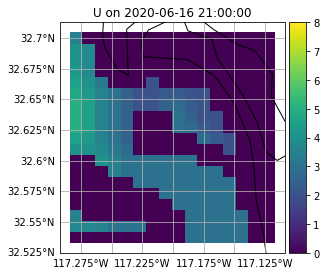

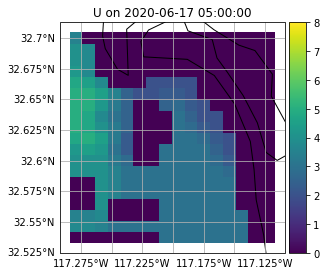

In [9]:
fs_radarnum = FieldSet.from_xarray_dataset(fs_xr, dict(U="number_of_sites",V="number_of_radials"), dict(lat="lat",lon="lon",time="time"))
fs_radarnum.U.show(vmax=8)
fs_radarnum.U.show(show_time=fs.U.grid.time[8], vmax=8)

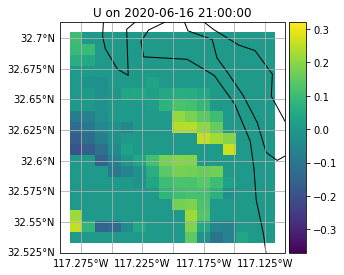

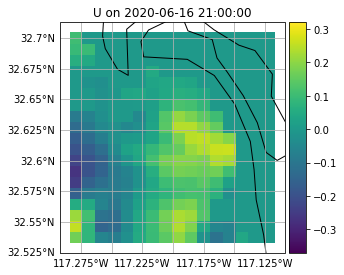

In [10]:
fs.U.show()
fs_interped.U.show()

In [11]:
time_range = fs.gridset.dimrange("time")
time_range

(0.0, 604800.0)

## Animated gif stuff

because it looks cool

In [22]:
# animation man very cool
# reference tutorial_Agulhasparticles
# needs ErrorCode for particle recovery
from parcels import ErrorCode

num_lon = 10
num_lat = 15
max_v = 1.1

interp = "linear"
fs.U.interp_method = interp
fs.V.interp_method = interp

def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
def exec_save_pset(pset, path, runtime, dt, maxv):
    pset.show(savefile=path, field='vector', land=True, vmax=maxv)
    
    pset.execute(AdvectionRK4,
                 runtime=timedelta(seconds=runtime),
                 dt=timedelta(seconds=dt),
                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

In [23]:
p_lons, p_lats = np.meshgrid(np.linspace(lon_range[0], lon_range[1], num_lon), np.linspace(lat_range[0], lat_range[1], num_lat))
pset_grid = ParticleSet(fieldset=fs, pclass=JITParticle, lon=p_lons, lat=p_lats, time=time_range[0])
pset_grid_interped = ParticleSet(fieldset=fs_interped, pclass=JITParticle, lon=p_lons, lat=p_lats, time=time_range[0])

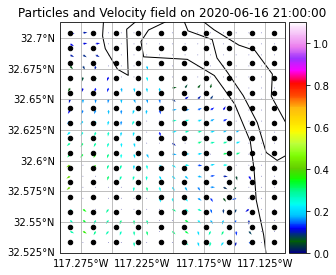

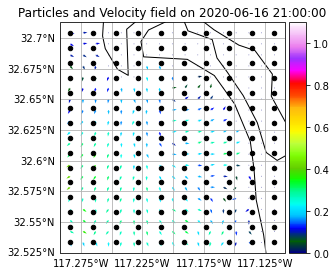

In [24]:
pset_grid.show(field="vector", vmax=max_v)
pset_grid_interped.show(field="vector", vmax=max_v)

In [25]:
import os

snapshot_interval = 3600 * 1 # seconds
p_dt = 300 # seconds
snapshot_num = math.floor((time_range[1] - time_range[0]) / snapshot_interval)
last_interval = time_range[1] - snapshot_num * snapshot_interval
if last_interval == 0:
    print(f"Snapshots to save: {snapshot_num + 1}")
else:
    print(f"Snapshots to save: {snapshot_num + 2}")
current_time = str(datetime.now().time())
save_dir = f"snapshots_{category}/"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    print(f"created directory {save_dir}")

Snapshots to save: 169


In [26]:
for i in range(snapshot_num):
    exec_save_pset(pset_grid, save_dir+"particles"+str(i).zfill(3), snapshot_interval, p_dt, max_v)
    exec_save_pset(pset_grid_interped, save_dir+"particles_interped"+str(i).zfill(3), snapshot_interval, p_dt, max_v)

# save the second-to-last frame
pset_grid.show(savefile=save_dir+"particles"+str(snapshot_num).zfill(3), field='vector', vmax=max_v)
pset_grid_interped.show(savefile=save_dir+"particles_interped"+str(snapshot_num).zfill(3), field='vector', vmax=max_v)

# run the last interval (the remainder) if needed
if last_interval != 0:
    exec_save_pset(pset_grid, save_dir+"particles"+str(snapshot_num + 1).zfill(3), last_interval, p_dt, max_v)
    exec_save_pset(pset_grid_interped, save_dir+"particles_interped"+str(snapshot_num + 1).zfill(3), last_interval, p_dt, max_v)

print("done")

INFO: Plot saved to snapshots_west_coast_1km_hourly/particles000.png
INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/7aed45ac006b2daa2760f73136a849ed_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/jerry/miniconda3/envs/py3_parc

INFO: Plot saved to snapshots_west_coast_1km_hourly/particles041.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped041.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles042.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped042.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles043.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped043.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles044.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped044.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles045.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped045.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles046.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped046.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles047.png
INFO: Plot saved to snapshots_west_coast_1km_hour

INFO: Plot saved to snapshots_west_coast_1km_hourly/particles097.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped097.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles098.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped098.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles099.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped099.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles100.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped100.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles101.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped101.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles102.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped102.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles103.png
INFO: Plot saved to snapshots_west_coast_1km_hour

INFO: Plot saved to snapshots_west_coast_1km_hourly/particles153.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped153.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles154.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped154.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles155.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped155.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles156.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped156.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles157.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped157.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles158.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles_interped158.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/particles159.png
INFO: Plot saved to snapshots_west_coast_1km_hour

done
